In [ ]:
import csv
import cv2 as cv
import numpy
import keras.backend as K
from keras.layers import Input, Conv2D, Activation, MaxPool2D, Flatten, Dense, BatchNormalization, Dropout
from keras import optimizers
from keras.applications.vgg16 import VGG16
from keras.initializers import glorot_uniform
from keras.models import Model, Sequential
from keras.utils import to_categorical
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

In [ ]:
X_train = []
Y_train = []

with open('/content/drive/MyDrive/images_color.csv', 'r') as f:
  reader = csv.reader(f)
  for row in reader:
    if row[0]!='':
      label = row[0]
      image = numpy.array([int(a) for a in row[1:]], dtype='uint8')
      image = image.reshape((32, 32, 3))
      image = cv.resize(image,(64, 64))
      X_train.append(image)
      Y_train.append(label)

X_train, _, Y_train, _ = train_test_split(X_train, Y_train, train_size=39208)
X_train = numpy.array(X_train)
Y_train = numpy.array(Y_train)

Y_train = to_categorical(Y_train)
print(X_train.shape)
print(Y_train.shape)


(39208, 64, 64, 3)
(39208, 43)


In [ ]:
X_test = []
Y_test = []

with open('/content/drive/MyDrive/test_set_in_csv.csv', 'r') as f:
  reader = csv.reader(f)
  header = next(reader)
  for row in reader:
    if len(row)!=0:
      label = row[0]
      image = numpy.array([int(a) for a in row[1:]], dtype='uint8')
      image = image.reshape((32, 32, 3))
      image = cv.resize(image, (64, 64))
      X_test.append(image)
      Y_test.append(label)

X_test = numpy.array(X_test)
Y_test = numpy.array(Y_test)

Y_test = to_categorical(Y_test)
print(X_test.shape)
print(Y_test.shape)

(12629, 64, 64, 3)
(12629, 43)


In [ ]:
def recall_m(y_true, y_pred):
    y_true = K.ones_like(y_true) 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    all_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    
    recall = true_positives / (all_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    y_true = K.ones_like(y_true) 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_score(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
def tsr_model(input_shape=(64, 64, 3)):
  model = Sequential()
  model.add(Input(input_shape))
  model.add(Conv2D(32, (3, 3), strides=(1, 1), padding='same', kernel_initializer=glorot_uniform(seed=0), activation='relu', name='conv1'))
  model.add(Conv2D(32, (3, 3), strides=(1, 1), padding='same', kernel_initializer=glorot_uniform(seed=0), activation='relu', name='conv2'))
  model.add(MaxPool2D((4, 4), strides=(4, 4)))
  model.add(Dropout(0.2))
  model.add(Conv2D(128, (3, 3), strides=(1, 1), padding='same', kernel_initializer=glorot_uniform(seed=0), activation='relu', name='conv3'))
  model.add(Conv2D(128, (3, 3), strides=(1, 1), padding='same', kernel_initializer=glorot_uniform(seed=0), activation='relu', name='conv4'))
  model.add(MaxPool2D((4, 4), strides=(4, 4)))
  model.add(Dropout(0.2))
  model.add(Conv2D(512, (3, 3), strides=(1, 1), padding='same', kernel_initializer=glorot_uniform(seed=0), activation='relu', name='conv5'))
  model.add(Conv2D(512, (3, 3), strides=(1, 1), padding='same', kernel_initializer=glorot_uniform(seed=0), activation='relu', name='conv6'))
  model.add(Conv2D(512, (3, 3), strides=(1, 1), padding='same', kernel_initializer=glorot_uniform(seed=0), activation='relu', name='conv7'))
  model.add(MaxPool2D((2, 2), strides=(2, 2)))
  model.add(Dropout(0.5))
  model.add(Flatten())
  model.add(Dense(2048, activation='relu', kernel_initializer=glorot_uniform(seed=0), name='fc1'))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))
  model.add(Dense(2048, activation='relu', kernel_initializer=glorot_uniform(seed=0), name='fc2'))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))
  model.add(Dense(43, activation='softmax', kernel_initializer=glorot_uniform(seed=0), name='fc3'))

  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
  return model

model = tsr_model(input_shape=(64, 64, 3))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 64, 64, 32)        896       
_________________________________________________________________
conv2 (Conv2D)               (None, 64, 64, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 32)        0         
_________________________________________________________________
conv3 (Conv2D)               (None, 16, 16, 128)       36992     
_________________________________________________________________
conv4 (Conv2D)               (None, 16, 16, 128)       147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 128)         0

In [ ]:
aug = ImageDataGenerator(rotation_range=10,
	zoom_range=0.15,
	width_shift_range=0.1,
	height_shift_range=0.1,
	shear_range=0.15,
	horizontal_flip=False,
	vertical_flip=False,
	fill_mode="nearest")

model.fit(aug.flow(X_train, Y_train, batch_size=128), epochs=30, batch_size=128, validation_data=(X_test, Y_test))

Epoch 1/30
307/307 [==============================] - 57s 174ms/step - loss: 4.5362 - accuracy: 0.0569 - val_loss: 3.4829 - val_accuracy: 0.0774
Epoch 2/30
307/307 [==============================] - 53s 172ms/step - loss: 3.6506 - accuracy: 0.0788 - val_loss: 3.3017 - val_accuracy: 0.1036
Epoch 3/30
307/307 [==============================] - 52s 170ms/step - loss: 3.5498 - accuracy: 0.0860 - val_loss: 3.0621 - val_accuracy: 0.1310
Epoch 4/30
307/307 [==============================] - 52s 170ms/step - loss: 2.6540 - accuracy: 0.2287 - val_loss: 2.3940 - val_accuracy: 0.2721
Epoch 5/30
307/307 [==============================] - 52s 170ms/step - loss: 1.8085 - accuracy: 0.3973 - val_loss: 1.7544 - val_accuracy: 0.4464
Epoch 6/30
307/307 [==============================] - 53s 174ms/step - loss: 1.7602 - accuracy: 0.4389 - val_loss: 1.0996 - val_accuracy: 0.6534
Epoch 7/30
307/307 [==============================] - 53s 171ms/step - loss: 0.9445 - accuracy: 0.6743 - val_loss: 0.5233 - val_ac

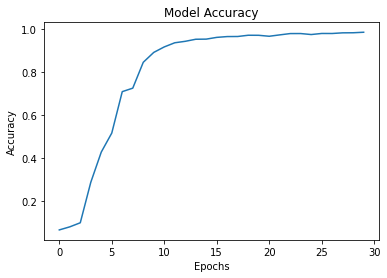

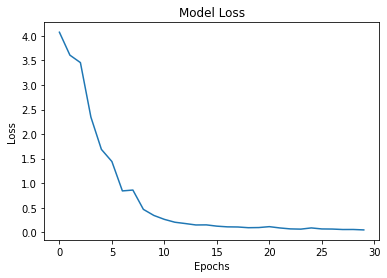

In [ ]:
from matplotlib import pyplot as plt
plt.plot(model.history.history['accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

plt.plot(model.history.history['loss'])
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [ ]:
model.save('/content/drive/MyDrive/tsr_model_v5.h5')

In [ ]:
from keras.models import load_model
import cv2 as cv
import numpy
import csv
from keras.utils import to_categorical
model = load_model('/content/drive/MyDrive/tsr_model_v5.h5')

In [ ]:
prediction = model.evaluate(X_test, Y_test)
print('loss : {}'.format(prediction[0]))
print('accuracy: {}'.format(prediction[1]))

395/395 [==============================] - 3s 8ms/step - loss: 0.1467 - accuracy: 0.9682
loss : 0.14668776094913483
accuracy: 0.9681684970855713


In [ ]:
from sklearn.metrics import classification_report
import numpy

y_pred = model.predict(X_test)
y_pred = numpy.argmax(y_pred, axis=1)
Y_test = numpy.argmax(Y_test, axis=1)
print(classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        59
           1       0.99      0.99      0.99       720
           2       0.97      0.99      0.98       750
           3       0.98      0.97      0.98       450
           4       0.99      0.97      0.98       660
           5       0.96      0.97      0.97       630
           6       1.00      0.89      0.94       150
           7       0.99      0.94      0.97       450
           8       0.95      0.96      0.96       450
           9       0.99      1.00      1.00       480
          10       1.00      0.99      0.99       660
          11       0.92      0.99      0.95       420
          12       1.00      0.97      0.98       690
          13       0.99      0.99      0.99       720
          14       1.00      1.00      1.00       270
          15       1.00      1.00      1.00       210
          16       1.00      1.00      1.00       150
          17       1.00    